# Bubble wall velocity under LTE

In [4]:
import numpy as np
from numpy import linalg as la
from scipy import integrate
from scipy import optimize
from scipy import interpolate
import scipy as sp
from matplotlib import pyplot as plt
import plotter as pl
from helperFunctions import derivative, alpha_p, cs_sq, dYdtau, dvTdxi, r_func, μ, w

Abs = np.abs
Log = np.log
Log10 = np.log10
Pi = np.pi
Sqrt = np.sqrt
Exp = np.exp
Cos = np.cos
Sin = np.sin
Sech = lambda x: 1/np.cosh(x)
Tanh = np.tanh
ArcSin = np.arcsin
ArcTanh = np.arctanh
Arg = np.angle
BesselK = sp.special.kv
Zeta = sp.special.zeta
HeavisideTheta = lambda x: np.heaviside(x, 0)


def Plot(fun, xminmax, n=100,xfun=np.linspace, xlog=False, ylog=False):
    xlist = xfun(xminmax[0], xminmax[1], n)
    ylist = [fun(x) for x in xlist]
    plt.plot(xlist, ylist)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

## Prepare

Import model

In [5]:
import SM_model as m

In [6]:
mod = m.SM(1,0.007285228,636.8644639563023)

Model inialized.
g2 = 1
λ = 0.007285228
μh = 25.236173718618723


In [7]:
mod.findTc()
mod.findTn()

Finding Tc...
Critical temperature found! Tc = 56.636213599704206
v_c/Tc = 2.805112061801922
Finding Tn...
Tunneling at T = 56.6162135997042
S3/T = 1776610.8191670412
Tunneling at T = 56.5962135997042
S3/T = 451853.4873529946
Tunneling at T = 56.576213599704204
S3/T = 203892.62078298946
Tunneling at T = 56.5562135997042
S3/T = 116379.02611931194
Tunneling at T = 56.536213599704205
S3/T = 75553.78882108373
Tunneling at T = 56.5162135997042
S3/T = 53207.22595090041
Tunneling at T = 56.496213599704205
S3/T = 39631.405949758664
Tunneling at T = 56.4762135997042
S3/T = 30754.56578833269
Tunneling at T = 56.456213599704206
S3/T = 24623.8127324952
Tunneling at T = 56.4362135997042
S3/T = 20206.51709158054
Tunneling at T = 56.4162135997042
S3/T = 16914.527917969783
Tunneling at T = 56.396213599704204
S3/T = 14392.707449727941
Tunneling at T = 56.3762135997042
S3/T = 12416.149909401369
Tunneling at T = 56.356213599704205
S3/T = 10836.68821998515
Tunneling at T = 56.3362135997042
S3/T = 9553.514

In [5]:
mod.findα()
mod.findβH()

α = 0.020951317965228568
β/H = 5236.3200587725305


In [8]:
Vtot=mod.Vtot
hv = np.array([0.0])
lv = np.array([mod.Tnvev])
Tnuc = mod.Tn

## Solving the boundary conditions for deflagration

In [39]:
def match(vp,vm,Tp,Tm, high_vev, low_vev):
    r = r_func(Vtot, Tp, Tm, high_vev, low_vev)
    αp = alpha_p(Vtot, Tp, Tm, high_vev, low_vev)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

def find_Tsh(Tm, vw):
    guess_sol = optimize.fsolve(lambda x:match(x[0], vw, x[1], Tm,hv, lv),[0.1,Tnuc])
    try:
        vsol=integrate.solve_ivp(dYdtau, (10,0.01), np.array([μ(vw, guess_sol[0]), guess_sol[1], vw]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
        xi_max = vsol.y[2].max()
        xi_max_index = vsol.y[2].argmax()
        v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
        T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
        try:
            xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, xi_max)
        except:
            xsh = xi_max
    except:
        vTsol = integrate.solve_ivp(dvTdxi, (vw, 1), np.array([μ(vw, guess_sol[0]), guess_sol[1]]), t_eval=np.linspace(vw, 1, 500), method='DOP853', args=(Vtot, hv))
        v_prof = interpolate.interp1d(vTsol.t, vTsol.y[0], kind='cubic')
        T_prof = interpolate.interp1d(vTsol.t, vTsol.y[1], kind='cubic')
        xsh = optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, 1)
    return T_prof(xsh)

In [8]:
Tnuc

53.3193823658802

In [40]:
find_Tsh(53, 0.1)

array(53.65717061)

In [8]:
Tmax = Tnuc
Tmin = 50
vw = 0.1
for i in range(30):
    Tcal=(Tmax+Tmin)/2
    Tsh = find_Tsh(Tcal, vw)
    if Tsh < Tnuc:
        Tmin = Tcal
    else:
        Tmax = Tcal
Tm = Tcal
vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tcal, hv, lv),[0.3, Tnuc], xtol=1e-10)
hv_new = mod.findMinimum(hv, Tp)
lv_new = mod.findMinimum(lv, Tm)

In [10]:
lv_new

array([195.53444997])

In [14]:
Tcal

52.54210004498391

In [15]:
Tm=optimize.newton(lambda T: find_Tsh(T, 0.1)-Tnuc, Tnuc-1)

In [11]:
vwlist[0]==0.1

True

## Solve the temperature profile and the moments

In [16]:
h0 = lv_new

def h_profile(z, Lh):
    z = np.asanyarray(z)
    hz = 0.5*h0*(1-np.tanh(z/Lh))
    return hz
c1 = w(Vtot, Tm, lv_new) * vw/(1-vw**2)
s1=c1
c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vw**2 /(1-vw**2)
s2=c2

In [17]:
def T33(T,z, Lh):
    derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
    field_value = [h_profile(z, Lh)]
    return (0.5*derh**2 - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

In [18]:
def moments(Lh):
    npoints = 100
    z_range = np.linspace(-8*Lh, 5*Lh, npoints)
    T_sol = np.zeros((npoints,))
    for i in range(npoints):
        T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tnuc, method='Nelder-Mead', bounds = [(40, 90)])
        if T33min.fun > 0:
            T_sol[i]=T33min.x[0]
        else:
            try:
                s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tnuc)
            except:
                s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tnuc)[0]
            T_sol[i] = s

    hvalues = h_profile(z_range, Lh)
    hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
    d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
    Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))
    
    Ph = np.trapz(- Eh * hprime(z_range), z_range)
    Gh = np.trapz( Eh * hprime(z_range) *(2*h_profile(z_range, Lh)/h0 - 1) , z_range)
    return np.array([Ph, Gh])/1e6

In [19]:
moments(2.0)

array([-1.19288966,  0.38371913])

In [20]:
optimize.newton(lambda L: moments(L)[-1], 0.1)

0.11399202408811979

In [42]:
vwlist = np.linspace(0.1,0.6,6)
vwlist[-1]= 0.53
Plist = np.zeros((6,))

In [41]:
def Ptot(vw):
    print("vw = " + str(vw))
    Tm = optimize.newton(lambda T: find_Tsh(T, 0.1)-Tnuc, Tnuc-1)
    print("Tm solved.")
    vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
    hv_new = mod.findMinimum(hv, Tp)
    lv_new = mod.findMinimum(lv, Tm)
    h0 = lv_new

    def h_profile(z, Lh):
        z = np.asanyarray(z)
        hz = 0.5*h0*(1-np.tanh(z/Lh))
        return hz
    c1 = w(Vtot, Tm, lv_new) * vw/(1-vw**2)
    s1=c1
    c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vw**2 /(1-vw**2)
    s2=c2

    def T33(T,z, Lh):
        derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
        field_value = [h_profile(z, Lh)]
        return (0.5*derh**2 - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

    print('T33 prepared.')
    
    def moments(Lh):
        npoints = 100
        z_range = np.linspace(-8*Lh, 5*Lh, npoints)
        T_sol = np.zeros((npoints,))
        for i in range(npoints):
            T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tnuc, method='Nelder-Mead', bounds = [(40, 90)])
            if T33min.fun > 0:
                T_sol[i]=T33min.x[0]
            else:
                try:
                    s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tnuc)
                except:
                    s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tnuc)[0]
                T_sol[i] = s

        hvalues = h_profile(z_range, Lh)
        hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
        d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
        Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))
    
        Ph = np.trapz(- Eh * hprime(z_range), z_range)
        Gh = np.trapz( Eh * hprime(z_range) *(2*h_profile(z_range, Lh)/h0 - 1) , z_range)
        return np.array([Ph, Gh])/1e6
    print('Solving moments.')
    Lsol = optimize.newton(lambda L: moments(L)[-1], 0.1)
    print('Moment solved, Lh = ' + str(Lsol))
    P = moments(Lsol)[0]
    return P

In [12]:
Ptot(0.53)

vw = 0.53
Tm solved.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.17716317200838919


0.3169573196945655

In [ ]:
for i in range(6):
    vw = vwlist[i]
    Plist[i] = Ptot(vw)

Text(0, 0.5, '$P_{\\rm tot}$')

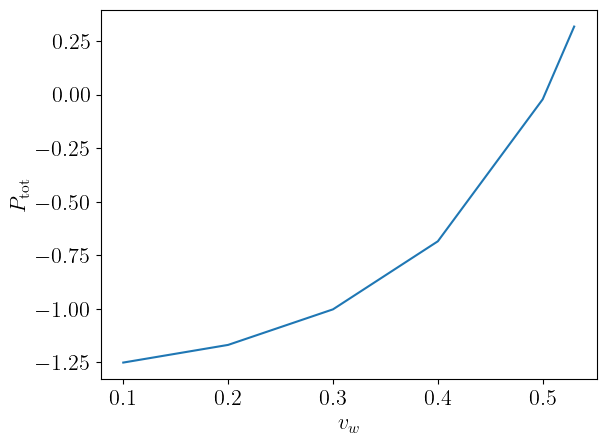

In [17]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')
plt.rc('font',size=16)
plt.plot(vwlist,Plist)
plt.xlabel(r'$v_w$')
plt.ylabel(r'$P_{\rm tot}$')

## Solve entropy vanishing instead of P vanishing

In [ ]:
def entropy(V,T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)

    def VT(T):
        return V(v, T)
    
    return -derivative(VT, T, order=1)

In [55]:
def sdiff(vw):
    print("vw = " + str(vw))
    Tm = optimize.newton(lambda T: find_Tsh(T, 0.1)-Tnuc, Tnuc-1)
    print("Tm solved.")
    vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
    hv_new = mod.findMinimum(hv, Tp)
    lv_new = mod.findMinimum(lv, Tm)

    diff = - Tp/Sqrt(1-vp) + Tm/Sqrt(1-vw)
    print(diff)
    return diff

In [52]:
sdiff(0.5)

vw = 0.5
Tm solved.
-4.762198012551394


-4.762198012551394

In [48]:
sdifflist = np.zeros((6,))

In [56]:
for i in range(6):
    sdifflist[i] = sdiff(vwlist[i])

vw = 0.1
Tm solved.
-0.16780950380412207
vw = 0.2
Tm solved.
0.6330390687882712
vw = 0.30000000000000004
Tm solved.
1.5907651070452005
vw = 0.4
Tm solved.
2.8687057715090845
vw = 0.5
Tm solved.
4.762198012551394
vw = 0.53
Tm solved.
5.5247532301036415


Text(0, 0.5, '$\\Delta (s \\gamma v)$')

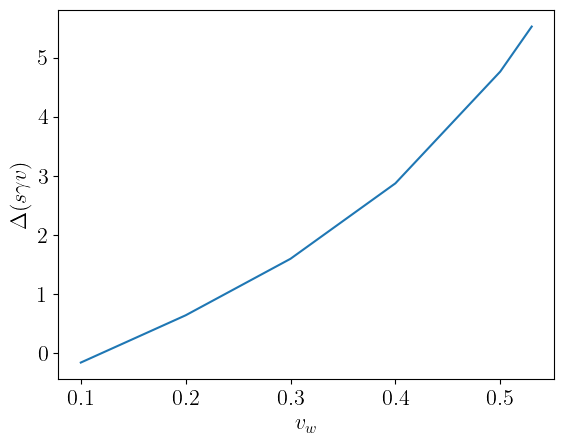

In [74]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')
plt.plot(vwlist, sdifflist)
plt.xlabel(r'$v_w$')
plt.ylabel(r'$\Delta (s \gamma v)$')

In [65]:
lv

array([190.80359172])

## Solve from entropy conservation

In [9]:
def entropy(V,T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)

    def VT(T):
        return V(v, T)
    
    return -derivative(VT, T, order=1)

def ω(V, T, vev):
    return T*entropy(V, T, vev)

In [75]:
def match_entropy_T30(vp, vm, Tp, Tm):
    T30 = ω(Vtot, Tp, hv) * vp/(1-vp**2)
    T30 -= ω(Vtot, Tm, lv) * vm/(1-vm**2)
    ds = Tm/Sqrt(1-vm**2) - Tp/Sqrt(1-vp**2)
    return np.array([T30, ds])

In [11]:
Tnuc

53.3193823658802

In [77]:
vw=0.3
Tm=53
optimize.fsolve(lambda sol: match_entropy_T30(sol[0],vw,sol[1],Tm), [vw*0.9,Tnuc])

array([ 0.21834159, 54.21858901])

In [35]:
def find_Tsh(Tm, vw):
    guess_sol = optimize.fsolve(lambda x:match_entropy_T30(x[0], vw, x[1], Tm),[0.1,Tnuc])
    try:
        vsol=integrate.solve_ivp(dYdtau, (10,0.01), np.array([μ(vw, guess_sol[0]), guess_sol[1], vw]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
        xi_max = vsol.y[2].max()
        xi_max_index = vsol.y[2].argmax()
        v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
        T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
        try:
            xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, xi_max)
        except:
            xsh = xi_max
    except:
        vTsol = integrate.solve_ivp(dvTdxi, (vw, 1), np.array([μ(vw, guess_sol[0]), guess_sol[1]]), t_eval=np.linspace(vw, 1, 500), method='DOP853', args=(Vtot, hv))
        v_prof = interpolate.interp1d(vTsol.t, vTsol.y[0], kind='cubic')
        T_prof = interpolate.interp1d(vTsol.t, vTsol.y[1], kind='cubic')
        xsh = optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, 1)
    return T_prof(xsh)

In [38]:
find_Tsh(53.1,0.3)

array(52.61598845)